# Check MUSIC on generated signals

## Imports and Constants

In [14]:
import math
import os
from itertools import combinations

import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize
from pyroomacoustics.transform import stft
from sklearn.metrics import confusion_matrix, accuracy_score

# Label resolution of angles
RESOLUTION = 10

# Determines the overlap of samples between consecutive features
STEP = 1024

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 3]),
    'medium' : np.array([6, 6, 3]),
    'large' : np.array([8, 8, 3])
}

# Testing rooms dimensions
TEST_ROOMS = {
    'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    'large' : np.array([9, 9, 2])
}

class Path:
    def __init__(self, name, path, max_angle):
        self.name = name
        self.path = path
        self.max_angle = max_angle

AUDIO_PATH = [
    Path('full', 'C:\\Users\\Alex\\source\\repos\\sound-localization\\data\\full_circle', 360),
    Path('half', 'C:\\Users\\Alex\\source\\repos\\sound-localization\\data\\half_circle', 180)
]

## Test on MUSIC

In [28]:
def compute_stft_matrix(signal, frame_size=256):    
    # Default value for overlap
    overlap = frame_size // 2
    
    # Calculate Short-time Fourier transform and return
    observation = stft.analysis(signal, L=frame_size, hop=overlap)

    # Transpose from [#freq_bins,#frames,#channels] to [#channels,#frames,#freq_bins]
    # [250, 129, 2] -> [2, 129, 250]
    return np.transpose(observation, axes=[2, 1, 0])



def get_music_prediction(X, max_angle, room_size='small', resolution=RESOLUTION, fs=16000, frame_size=256):    
    # Get microphone locations
    w = ROOMS[room_size][0]
    l = ROOMS[room_size][1]
    h = ROOMS[room_size][2]
    mic_pos=np.c_[[w/2+0.1, 0, 0],[w/2-0.1, 0, 0]] 

    # Run MUSIC (MUltiple SIgnal Classication) algorithm for DOA (direction-of-arrival)
    doa = pra.doa.MUSIC(mic_pos, fs, nfft=frame_size, n_grid=(360 // resolution), num_src=1)
    doa.locate_sources(X)
    pred = doa.azimuth_recon[0] 

    # Account for angles from 0 to 180 only
    if max_angle == 180:
        if pred > np.pi:
            pred = (2 * np.pi - pred) * 180 / np.pi
        else:
            pred =  pred * 180 / np.pi
    
    return round(pred)



def get_all_predictions(resolution=RESOLUTION, audio_path=AUDIO_PATH[1]):    
    y_true = []
    y_pred = []
    info = []
    
    files = [file for file in os.listdir(audio_path.path)]

    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav': 
            continue

        path = os.path.join(audio_path.path, file)
        fs, wav_signals = wavfile.read(path)
        label = int(file.split('_')[2])
        
        # Get the file information (distance, room type, sound signal angle)
        dist = int(file.split('_')[4])
        room = file.split('_')[6]
        y = [(dist, room, label)]
        
        # Convert the wav signal into frequency domain
        X = compute_stft_matrix(wav_signals)
        pred = get_music_prediction(X, audio_path.max_angle, room_size=room, resolution=resolution)

        # Store actual and predicted labels
        y_true.extend(y)
        y_pred.append(pred) 
        print(f'File {i+1}/{len(files)}', end='\r')
       
    y_true = np.array(y_true)
    
    info = y_true[:, :-1]
    y_true = list(y_true[:, -1].astype(int))
    y_pred = list(np.array(y_pred).astype(int))
    return y_true, y_pred, info

In [29]:
y_true, y_pred, info = get_all_predictions(resolution=RESOLUTION, audio_path=AUDIO_PATH[1])

In [30]:
def plot_cm(y_true, y_pred, class_names, font_scale=0.8):
    cm = confusion_matrix(y_true, y_pred, normalize='true')    
    fig, ax = plt.subplots(figsize=(24, 20)) 
    ax = sns.heatmap(cm, annot=True, fmt=".3f", ax=ax)

    plt.ylabel('Actual', fontsize=30)
    plt.xlabel('Predicted', fontsize=30)
    ax.set_xticklabels(class_names, fontsize=24)
    ax.set_yticklabels(class_names, rotation=0, fontsize=24)
    plt.show()
    
    
def rmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total = sum(min(abs(y_t - y_p), (180 - abs(y_t - y_p))) ** 2 for y_t, y_p in zip(y_true, y_pred))
    rms = ((total / len(y_true)) ** 0.5)
    
    if type(rms) == np.ndarray:
        rms = rms[0]
        
    return round(rms, 3)

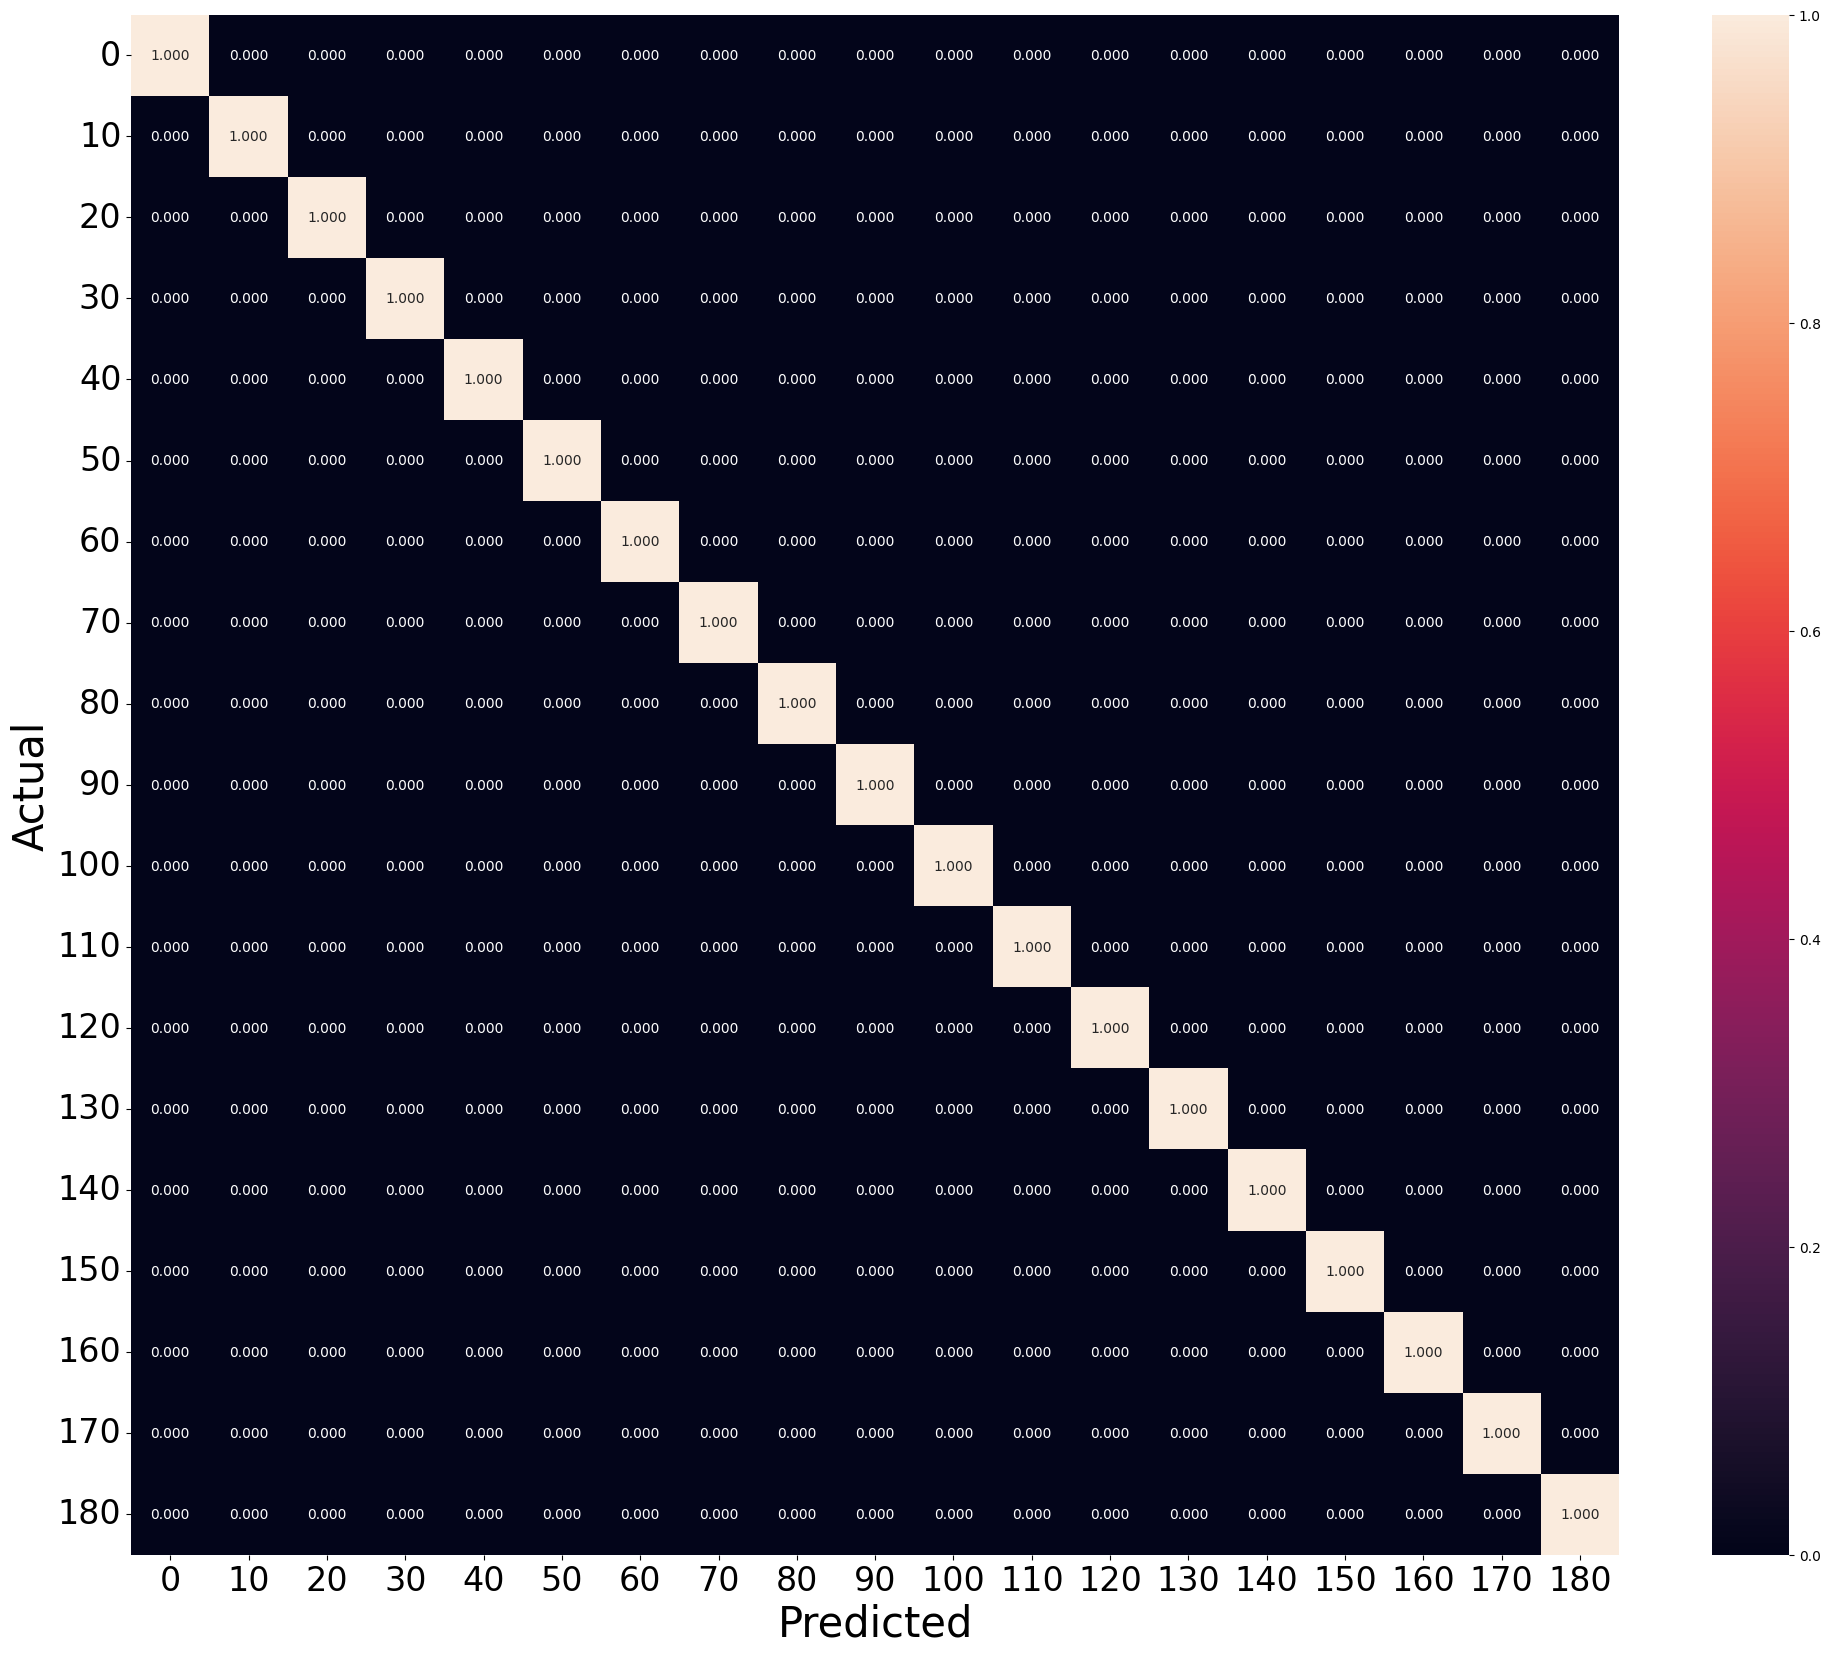

Accuracy: 1.0
RMSE: 0.0


In [31]:
# Plot confusion matrix and report accuracy
plot_cm(y_true, y_pred, np.unique(y_true))
accuracy = accuracy_score(y_true, y_pred)

print(f'Accuracy: {round(accuracy, 3)}')
print(f'RMSE: {rmse(y_true, y_pred)}')

In [32]:
def get_entries_with_property(info, prop, value):
    if prop == 'distance': i = 0
    elif prop == 'room': i = 1
        
    info = info[:, i]
    return np.where(info == value)

# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    indices = get_entries_with_property(info, 'room', room)
    y_true_room, y_pred_room = np.take(y_true, indices)[0], np.take(y_pred, indices)[0]
    accuracy = accuracy_score(y_true_room, y_pred_room)
    print(f"- {room} room accuracy: {round(accuracy, 3)}")
    
print('\nDistances')
for dist in np.unique(info[:, 0]):
    indices = get_entries_with_property(info, 'distance', dist)
    y_true_dist, y_pred_dist = np.take(y_true, indices)[0], np.take(y_pred, indices)[0]
    accuracy = accuracy_score(y_true_dist, y_pred_dist)
    print(f"- {dist} cm distance accuracy: {round(accuracy, 3)}")

Room sizes
- small room accuracy: 1.0
- medium room accuracy: 1.0
- large room accuracy: 1.0

Distances
- 100 cm distance accuracy: 1.0
- 200 cm distance accuracy: 1.0
